# Predictive Analysis on PlaiCraft Dataset

# Introduction 
The purpose of this Data Science Project is to perform an analysis to answer a predictive question using the Minecraft server, PlaiCraft, dataset. Specifically, we'd like to better understand the details regarding player engagement and demographics. This dataset was collected by a research group in Computer Science at UBC to explore how people play video games throughout the past couple of years. This final report will be a continuation of the planning stages from the Individual Planning Report of the exploratory analysis performed regarding the variables chosen to further our analysis using predictive methods to answer the question. 


## Data Description

 The data being used on this project was collected by having individuals play on UBC's research group's Mincraft served called PlaiCraft. The data collected consisted of information such as player experience, their session durations, and furthmore. The files we are presented with consists of players.csv and sessions.csv:

#### Players Dataset
The players.csv file contains information collected from the Minecraft server with 197 observations and 7 columns. Each observation is representative of a player. 

Further information about the dataset can be seen in the following table:

|  Variable Name | Variable Data Type |                          Description                                | 
|:--------------:|:------------------:|:-------------------------------------------------------------------:|
|  experience    |  Character         |   Describes if a player is a Pro, Veteran, Beginner or Amateur	    |  
|  subscribe     |  Logical           |   Denotes if a player has subscribed to PlaiCraft's email updates   |   
|  hashedEmail   |  Character         |   The hashed email for each player                                  |  
| played_hours   |  Double            |   The total number of hours a player has played                     |
|  name          |  Character         |   The player's alias                                                |  
|  gender        | Character          |   The player's gender, either male or female                        |  
|  age           |  Double            |   The player's age                                                  | 

To provide further context, "hashedEmail" represents different combined sequences of letters and numbers which encodes for the player's real email. This information is encoded because it is private information and therefore not shared.
Furthermore, there are two additional columns in the Player’s dataset named “individualId” and “organizationName.” These columns are redundant because they all have NA values (missing values) because they represent if the data was collected from individual servers or by an organization in which is unnecessary information for our goal. With that said, these columns have been excluded from our analysis. 

#### Sessions Dataset
The sessions.csv file contains information collected from the Minecraft server with 1535 observations and 5 columns. Each observation is representative of a player's playing session, noting the start and end times of that session.
Further information about the dataset can be seen in the following table:

|  Variable Name       | Variable Data Type |                          Description                                | 
|:--------------------:|:------------------:|:-------------------------------------------------------------------:| 
|  hashedEmail         |  Character         |   The hashed email for each player                                  |  
|  start_time          |  Character         |   The player's actual start time of the session                     |
|  end_time            |  Character         |   The player's actual end time of the session                       |  
|  original_start_time |  Double            |   The player's scheduled start times in UNIX timestamp format       |  
|  original_end_time   |  Double            |   The player's scheduled end times in UNIX timestamp format         | 

Similiar to the players dataset, "hashedEmail" is a player's encoded real email, which is a common factor in the sessions and players dataset. This hashedEmail may be used to combine the information between the two datasets, so they can be processed into one dataset, which can be seen later. 

## Question 
The overall question is to discover which player contribute to the most amount of data in order to target those players in recruiting efforts. Specifically, our group would like to predict a player’s playtime based on their age and/or experience level in order to determine what age range or experience levels contribute most to the number of hours played. By identifying these key factors, we aim to target players more effectively during recruitment and marketing efforts. 

## Methods

To do this, we will create a linear regression model to satisfy our prediction. We will begin by first preprocessing out data and performing an exploratory analysis to examine the relationship between playtime and predictors - age, gender, and experience level. This analysis will help us identify patterns and correlations in the data. After exploring the relationships, we will select the most relevant predictors for the model and use them to build a linear regression model. The model will then be trained to predict playtime based on the predictor(s) chosen and using a 75-25 training to test data split. Finally, the model's performance will be evaluated using Root Mean Squared Error to measure the model's accuracy.  

# Analysis

This section contains the information regarding the analysis of the project. The analysis will consist of preprocessing the data and afterwards, splitting the data into training and testing sets to generate the model. Finally, the model will be evaluated for its performance.



## Loading and Wrangling Data

Prior to the analysis, the data must be preprocessed, a process commonly referred to as data wrangling. During this phase, we identified an issue within the sessions dataset: the columns labeled "original_start_time" and "original_end_time" contained rounded recorded times for each player's session. This may be observed in Table 2 below.  These rounded times are of no value, because for example, sessions under 60 minutes were rounded to 0 minutes. As a result, these columns were deemed unnecessary and will be excluded from the dataset. Instead, the start and end times were used. These timestamps were provided as a character data type, which were converted into "POSIXct" format, and then used to calculate the session durations. 

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library (lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read_csv ("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")|>
    select(-individualId, -organizationName)

sessions_data <- read_csv ("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Table 1. Players Dataset 

In [3]:
head(players_data) 

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


#### Table 2. Sessions Dataset 

In [4]:
head(sessions_data) 


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


## Further Wrangling 
The sessions were then grouped by each player's hashed emails to then summarize the total sum of playtime minutes. Afterwards, the players and sessions dataset were combined by linking the "hashed emails" together and converting them to ID numbers since the hashed emails contained no significant value. The final result of the wrangled data can be seen in Table 3 below. 

In [5]:
players_analysis_data <- sessions_data |> 
    mutate (start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate (end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))|>
    mutate (converted_end_sec = as.numeric(as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))) |>
    mutate (converted_start_sec = as.numeric(as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"))) |>
    mutate (duration = (converted_end_sec - converted_start_sec )/(60)) |>
    select (-original_start_time, -original_end_time)|>
    group_by (hashedEmail)|>
    summarize(total_duration_min = sum(duration))

In [6]:
combined_data <- left_join(players_data, players_analysis_data, by="hashedEmail") |>
    mutate(total_duration_min = replace_na(total_duration_min, 0)) |>
    mutate(id_number = row_number())|>
    select (id_number, everything(), - hashedEmail, -name)

#### Table 3. Combined Wrangled Data  

In [7]:
head(combined_data) 

id_number,experience,subscribe,played_hours,gender,age,total_duration_min
<int>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>
1,Pro,TRUE,30.3,Male,9,2019
2,Veteran,TRUE,3.8,Male,17,255
3,Veteran,FALSE,0.0,Male,17,5
4,Amateur,TRUE,0.7,Female,21,50
5,Regular,TRUE,0.1,Male,21,9
6,Amateur,TRUE,0.0,Female,17,0


To further prepare for the linear regression model, we needed to convert categorical variables such as experience level and gender into numerical values. We chose to convert the experience level and gender with the associated numbers below.

|  Experience      | Numerical Value  |
|:----------------:|:----------------:|
|  Amateur         |  1               | 
|  Beginner        |  2               | 
|  Regular         |  3               |
|  Pro             |  4               |  
|  Veteran         |  5               |

|  Gender          | Numerical Value  |
|:----------------:|:----------------:|
|  Female         |  1               | 
|  Male           |  2               | 
|  Non-Binary     |  3               |
|  Agender        |  4               |  
|  Two-spirited   |  5               |
|  Other          |  6               |
|  Prefer not to say   |  7          |

In [8]:
raw_data <- combined_data|>
    mutate(numerical_experience = case_when(
    experience == "Amateur" ~ 1,
    experience == "Beginner" ~ 2,
    experience == "Regular" ~ 3,
    experience == "Pro" ~ 4,
    experience == "Veteran" ~ 5)) |>
    mutate(numerical_gender = case_when(
        gender == "Female" ~ 1,
        gender == "Male" ~ 2,
        gender == "Non-binary" ~ 3, 
        gender == "Agender" ~ 4,
        gender == "Two-Spirited" ~ 5, 
        gender == "Other" ~ 6,
        gender == "Prefer not to say" ~ 7))
           


The data is now tidy and converted into formats that are applicable for our linear regression model.

#### Table 4. Combined Tidy Data

In [9]:
head(raw_data) 

id_number,experience,subscribe,played_hours,gender,age,total_duration_min,numerical_experience,numerical_gender
<int>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Pro,TRUE,30.3,Male,9,2019,4,2
2,Veteran,TRUE,3.8,Male,17,255,5,2
3,Veteran,FALSE,0.0,Male,17,5,5,2
4,Amateur,TRUE,0.7,Female,21,50,1,1
5,Regular,TRUE,0.1,Male,21,9,3,2
6,Amateur,TRUE,0.0,Female,17,0,1,1


## Filtering Data to Remove Outliers

There are outliers in the data set that can be removed to create a better model. We can visualize the duration played in a histogram to choose a limit to the duration played.

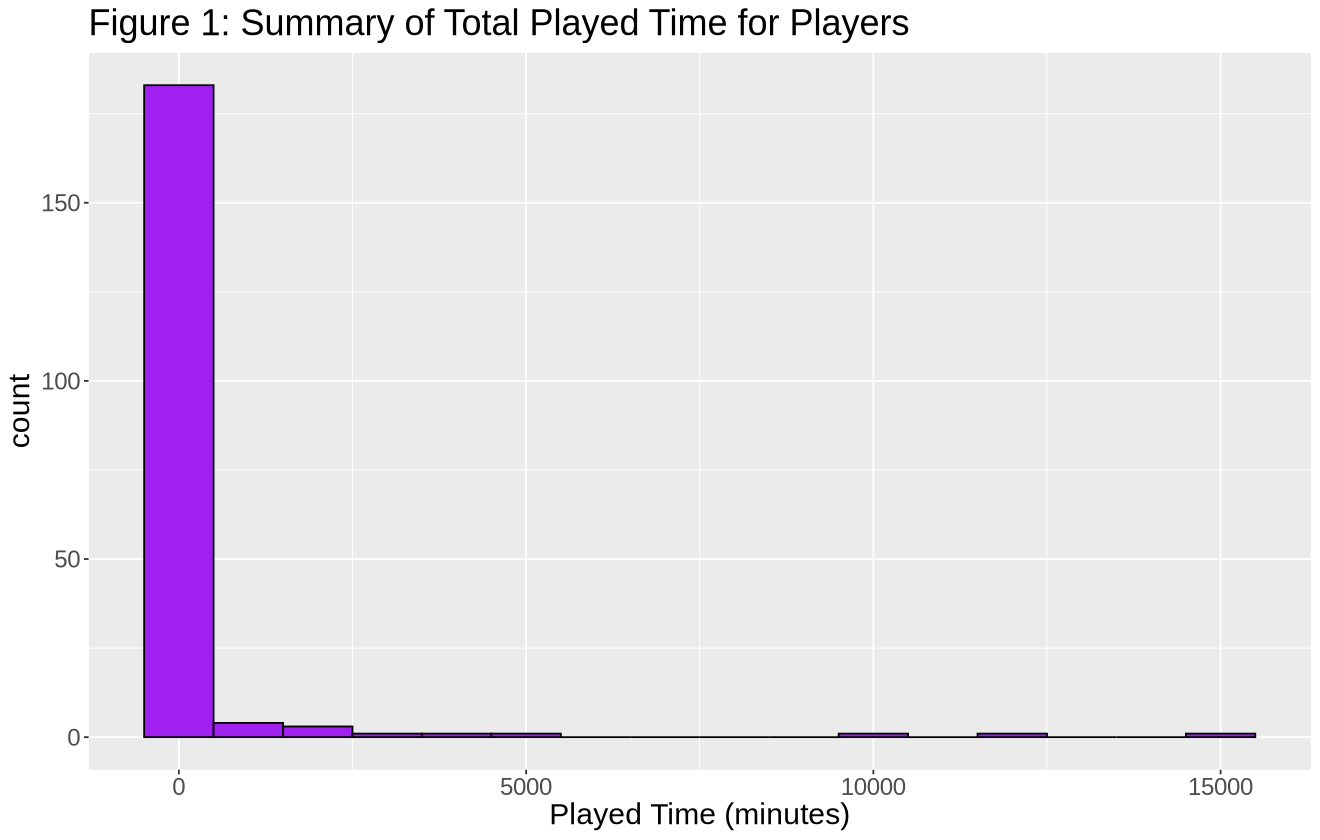

In [10]:
options(repr.plot.width = 11, repr.plot.height = 7)  

Played_time_hist<- raw_data |>
                    ggplot(aes(x = total_duration_min))+
                    geom_histogram(binwidth = 1000, fill = "purple", colour = "black") +
                    labs(x = "Played Time (minutes)", title= "Figure 1: Summary of Total Played Time for Players") +
                    theme(text = element_text(size = 18)) 
Played_time_hist

Most of the duration played occurs from 0 - 900 minutes as seen in the height of the bars in the histogram. We will set the limit of the duration played to 900 minutes. 

Next we will investigate the outliers for the age of players with a histogram:

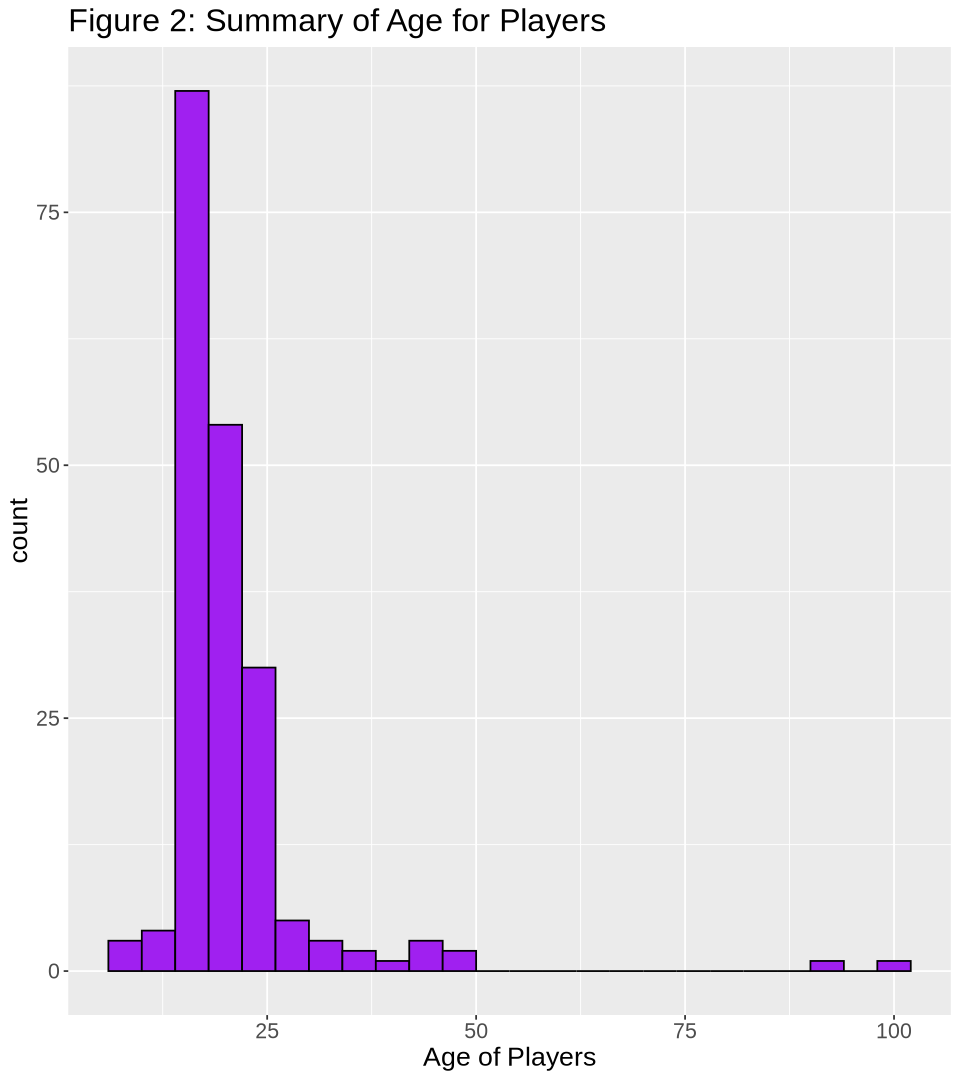

In [11]:
options(repr.plot.width = 8, repr.plot.height = 9) 
Age_hist<- raw_data |>
                    ggplot(aes(x = age))+
                    geom_histogram(binwidth = 4, fill = "purple", color = "black") +
                    labs(x = "Age of Players", title= "Figure 2: Summary of Age for Players") +
                    theme(text = element_text(size = 16))
Age_hist

There are two outliers that occur past the age of 50. We will limit the age to 50 years old. They are considered outliers as they fall outside the typical range of most players in the dataset. 

The data is filtered as follows:

In [12]:
set.seed(2000)
combined_data <- raw_data |>
    filter(age <=50) |> 
    filter(total_duration_min <=900) 


## Splitting the Data Set

To create a linear regression model, we will split the data set into a training and testing set so that root mean squared error can be determined and the accuracy of the model can be evaluated.

In [13]:
data_split <- initial_split(combined_data, prop = 0.75, strata = total_duration_min) 

data_training <- training(data_split)
data_testing <- testing(data_split)

## Investigating Relationships with Visualizations

First, we will investigate the relationship between the duration played and the experience level of the player where each experience level is assigned to a numerical value. In the wrangled data above, "Amateur" was given a value of 1, "Beginner" was assigned a value of 2, etc.

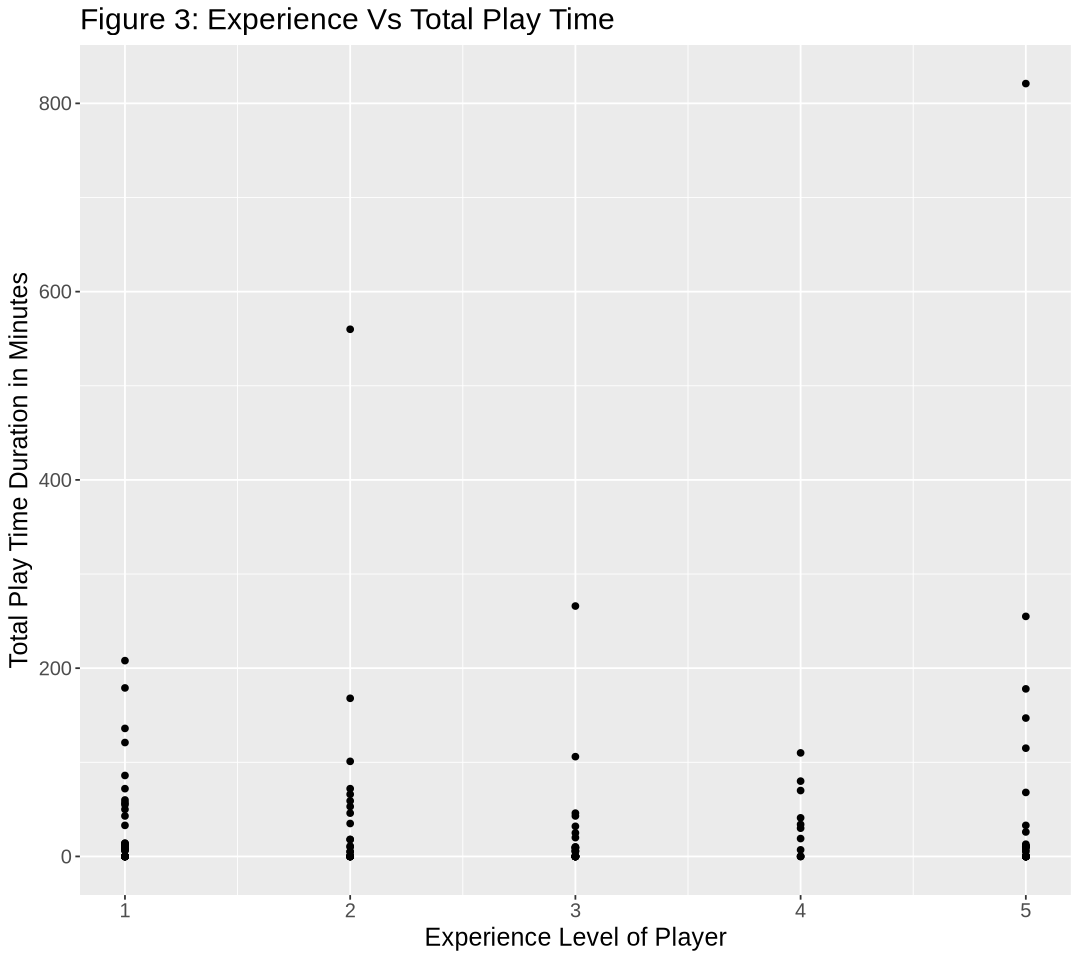

In [14]:
options(repr.plot.width = 9, repr.plot.height = 8) 

raw_training_plot <- data_training |>
    ggplot(aes (x = numerical_experience, y= total_duration_min)) +
    geom_point()+
    labs(x = "Experience Level of Player",
         y = "Total Play Time Duration in Minutes",
        title = "Figure 3: Experience Vs Total Play Time") +
        theme(text = element_text(size = 15))

raw_training_plot

The scatter plot data is not usable as the points are all focused on the integers due to the experience level of the player being a categorical variable. The data does not show a linear relationship and would not be suited for the linear regression model that we want to apply. 

This data would be better represented as a bar graph:

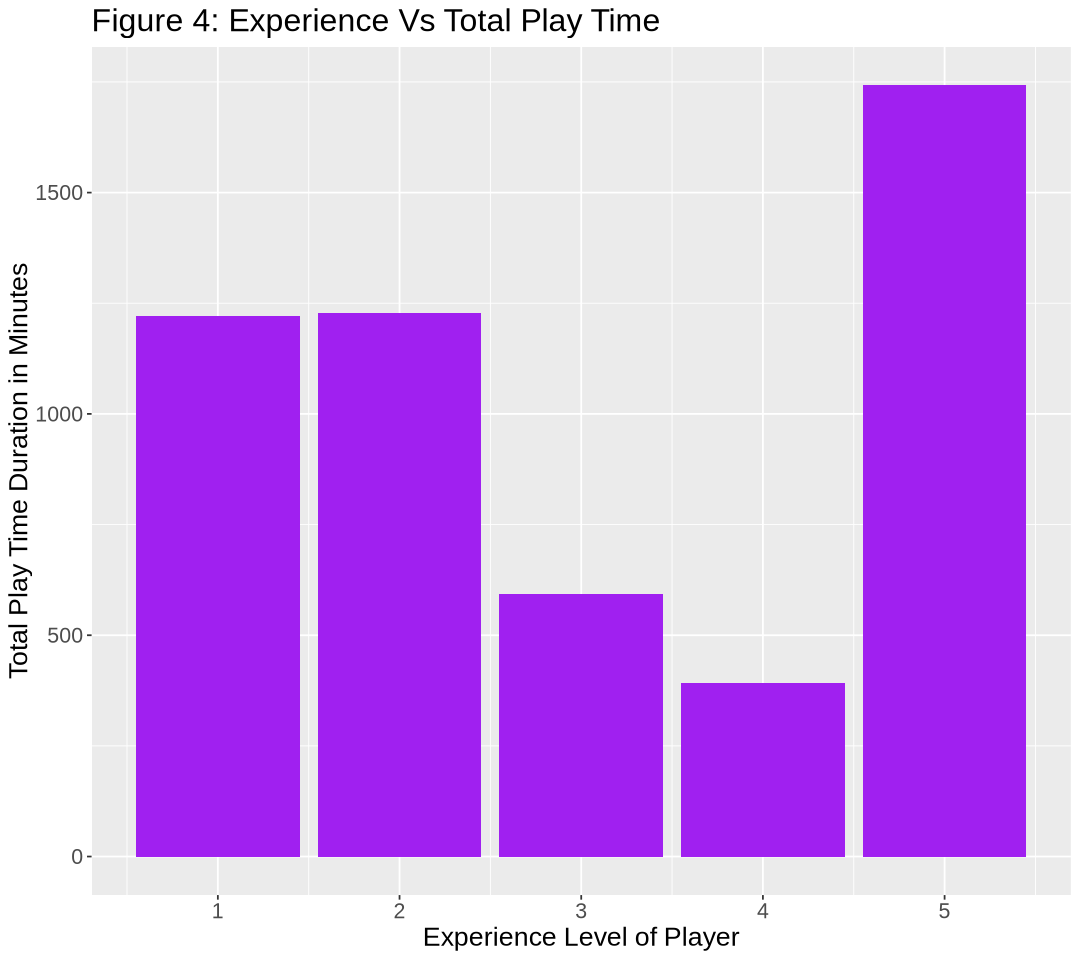

In [15]:
options(repr.plot.width = 9, repr.plot.height = 8) 

raw_training_bar <- data_training |>
    ggplot(aes(x = numerical_experience, y = total_duration_min)) +
    geom_bar(stat = "identity", fill = "purple") +
    labs(x = "Experience Level of Player",
         y = "Total Play Time Duration in Minutes",
         title = "Figure 4: Experience Vs Total Play Time") +
        theme(text = element_text(size= 16))

raw_training_bar

We see a similar result when visualizing the relationship between gender and the time played:

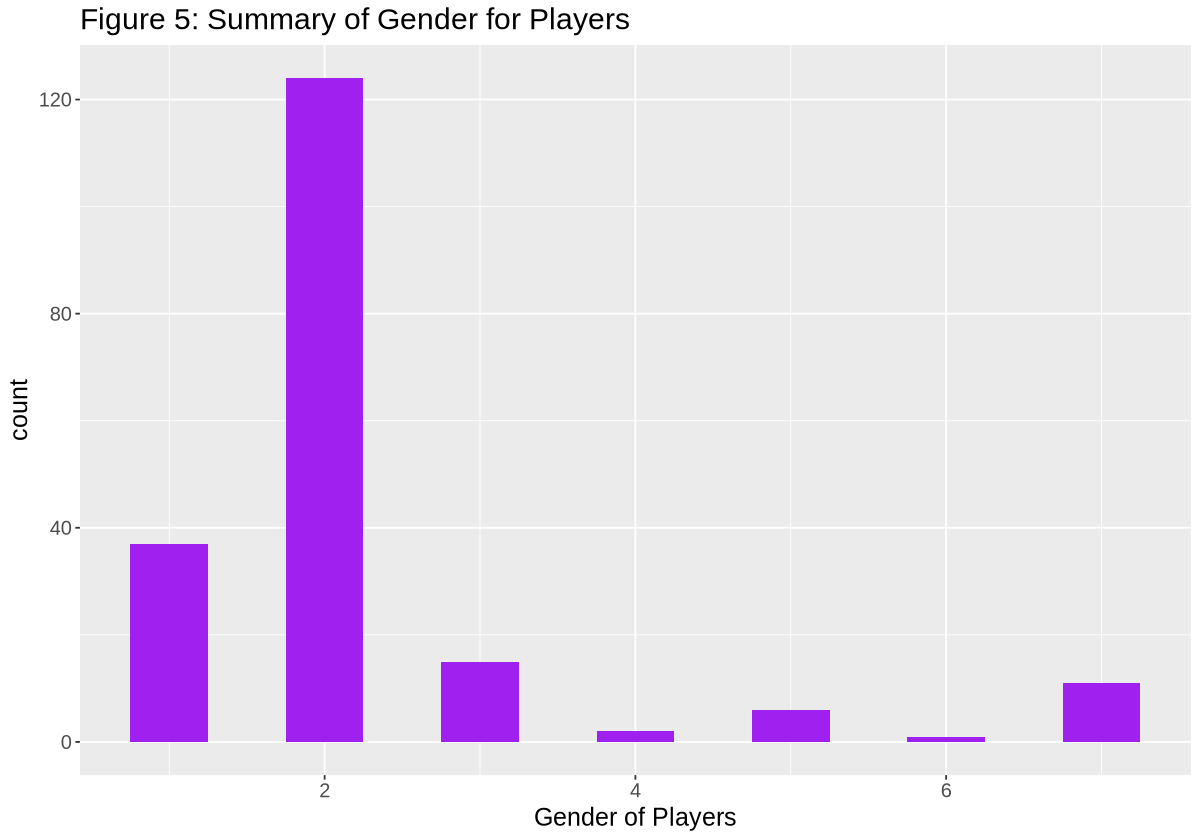

In [16]:
options(repr.plot.width = 10, repr.plot.height = 7)  

 Gender_hist <- raw_data |>
                    ggplot(aes(x = numerical_gender))+
                    geom_histogram(binwidth = 0.5, fill = "purple") +
                    labs(x = "Gender of Players", title= "Figure 5: Summary of Gender for Players") +
                    theme(text = element_text(size = 15))

Gender_hist

This histogram helps visualize how Gender is distributed in the data set. Each bin represents a type of Gender. Since Gender is a categorical variable, we assigned it to numbers from 1-7 in order to attempt setting it to a regression type model. Clearly, Gender is not a continuous variable to assess as a regression model because of its discontinuity from deriving from a categorical variable. Therefore, since there are only a fixed amount of variables, there isn’t enough data for Gender to be a variable in our linear regression model and therefore is disregarded. Furthermore, since gender and play-time don't have a linear relationship, a linear regression model with gender as a predictor would not be suitable.

Next, we will investigate the relationship between the duration played and age:

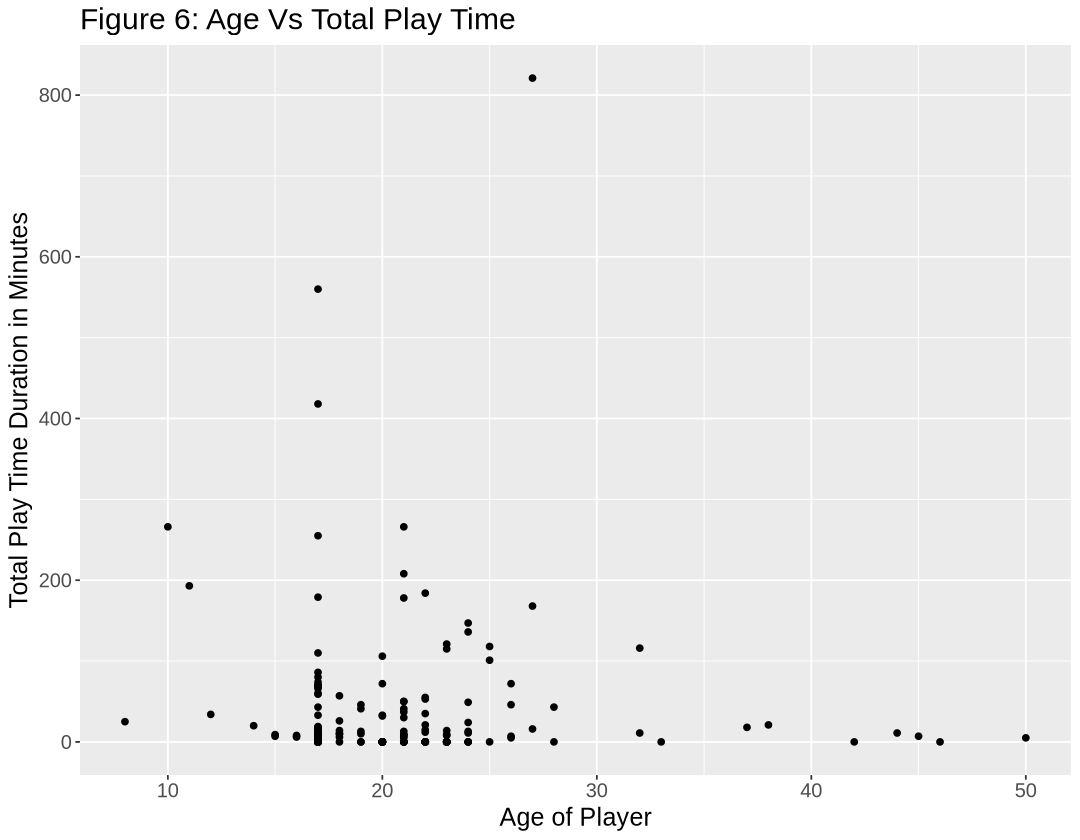

In [17]:
options(repr.plot.width = 9, repr.plot.height = 7) 

raw_training_plot <- combined_data |>
    ggplot(aes (x = age, y= total_duration_min)) +
    geom_point()+
    labs(x = "Age of Player",
         y = "Total Play Time Duration in Minutes",
        title = "Figure 6: Age Vs Total Play Time") +
       theme(text= element_text(size = 15))

raw_training_plot

This plot has a much better spread of data compared to the other variables because the range is greater. While age is still a categorical variable, there is enough of a range of data for the data to display continous properties. Furthermore, there is a weak linear relationship oberved between age and playtime, which makes the predictor suitable for our purposes. Therefore in our model, we will have age as the only predictor variable.

# Methods and Results

## Regression Model

The data was already split earlier in the analysis. To start, we will build a model only for the training data to allow us to assess the model in later steps. A recipe with age as the predictor variable is added as well as a model specification using the `linear_reg()` function and setting the engine and mode appropriately for regression. The recipe and model specification will then be fitted to the training data set with the `workflow()` function.

In [18]:
lm_recipe <- recipe(total_duration_min ~ age, data = data_training)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode ("regression")

lm_fit <- workflow() |>
      add_recipe(lm_recipe) |>
      add_model(lm_spec) |>
      fit(data = data_training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
   36.86974      0.05762  


##### A visualization of the training set with the regression line on the plot of age against time played in minutes is as follows:

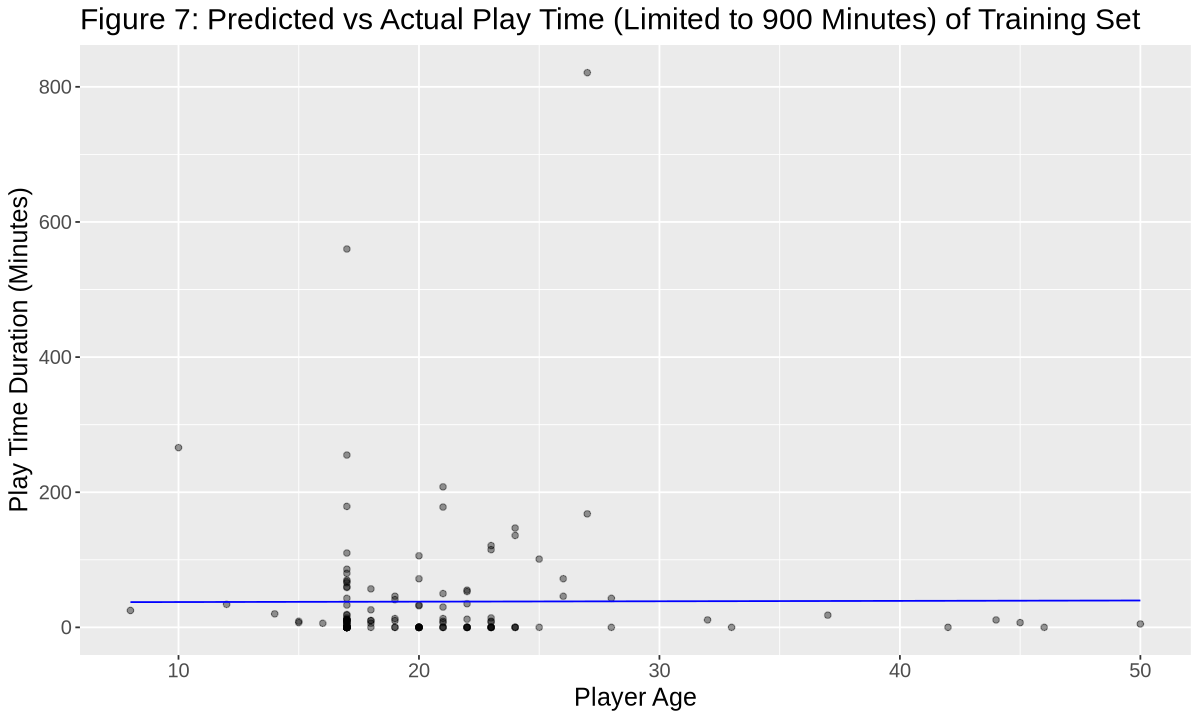

In [19]:
options(repr.plot.width = 10, repr.plot.height = 6) 

data_preds <- lm_fit |>
  predict(data_training) |>
  bind_cols(data_training)

lm_predictions <- data_preds |>
    ggplot(aes(x = age, y = total_duration_min)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = age, y = .pred), 
            color = "blue") +
        xlab("Player Age") +
        ylab("Play Time Duration (Minutes)") +
        ggtitle("Figure 7: Predicted vs Actual Play Time (Limited to 900 Minutes) of Training Set")+
        theme(text = element_text(size = 15))

lm_predictions

We can predict on the test data set to assess how well our model does by finding the RMSPE (root mean squared prediction error).

In [20]:
lm_test_results <- lm_fit |>
        predict(data_testing) |>
        bind_cols(data_testing) |>
        metrics(truth = total_duration_min, estimate = .pred)

lm_rmspe <- lm_test_results |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

[1] 79.05092

#### The RMSPE of our model is 79 minutes.

We can also visualize the regression line on the testing data set on a plot of age against played time.

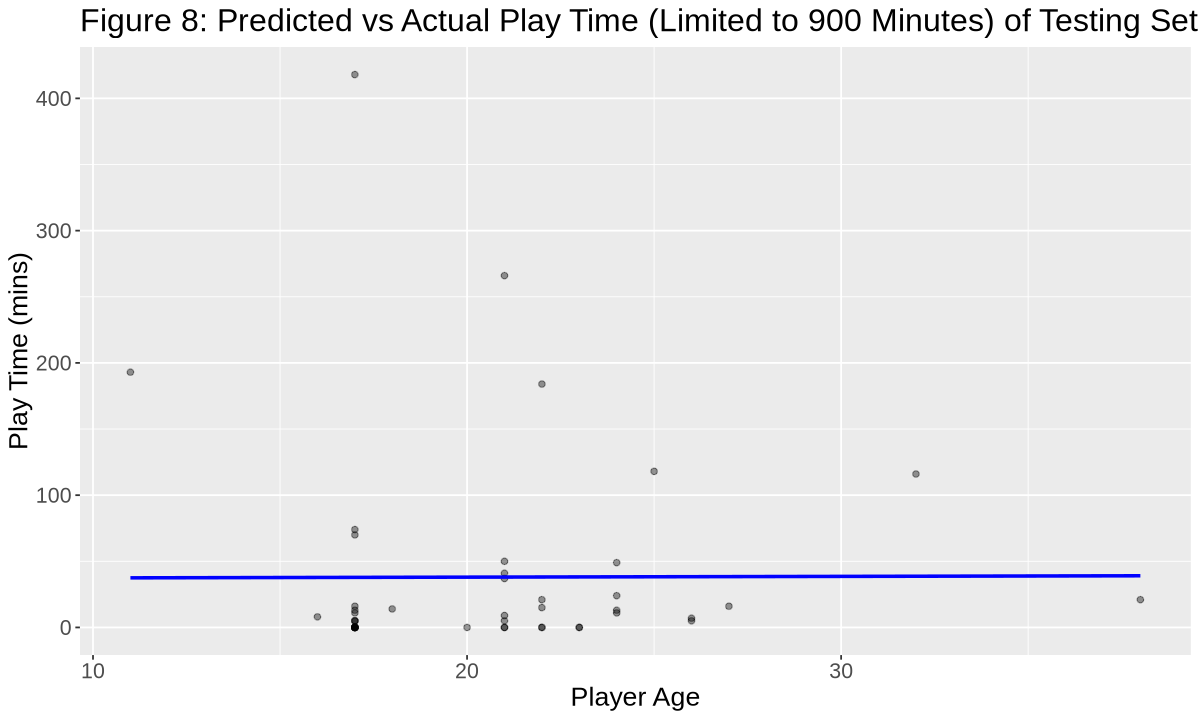

In [21]:
options(repr.plot.width = 10, repr.plot.height = 6) 

test_preds <- lm_fit |> 
    predict(data_testing) |>
    bind_cols(data_testing) 
    
lm_predictions_test <- test_preds |> 
    ggplot(aes (x=age, y = total_duration_min)) +
    geom_point(alpha = 0.4) +
    geom_line(
        data = test_preds, 
        mapping = aes (x = age, y = .pred),
        colour = "blue",
        linewidth = 1) +
    labs(x = "Player Age",
         y = "Play Time (mins)",
        title= "Figure 8: Predicted vs Actual Play Time (Limited to 900 Minutes) of Testing Set") +
        theme(text = element_text(size = 16))

lm_predictions_test

Combining the data together, we can make a plot with all of the data points from the combined data frame and include the regression line made by our model:

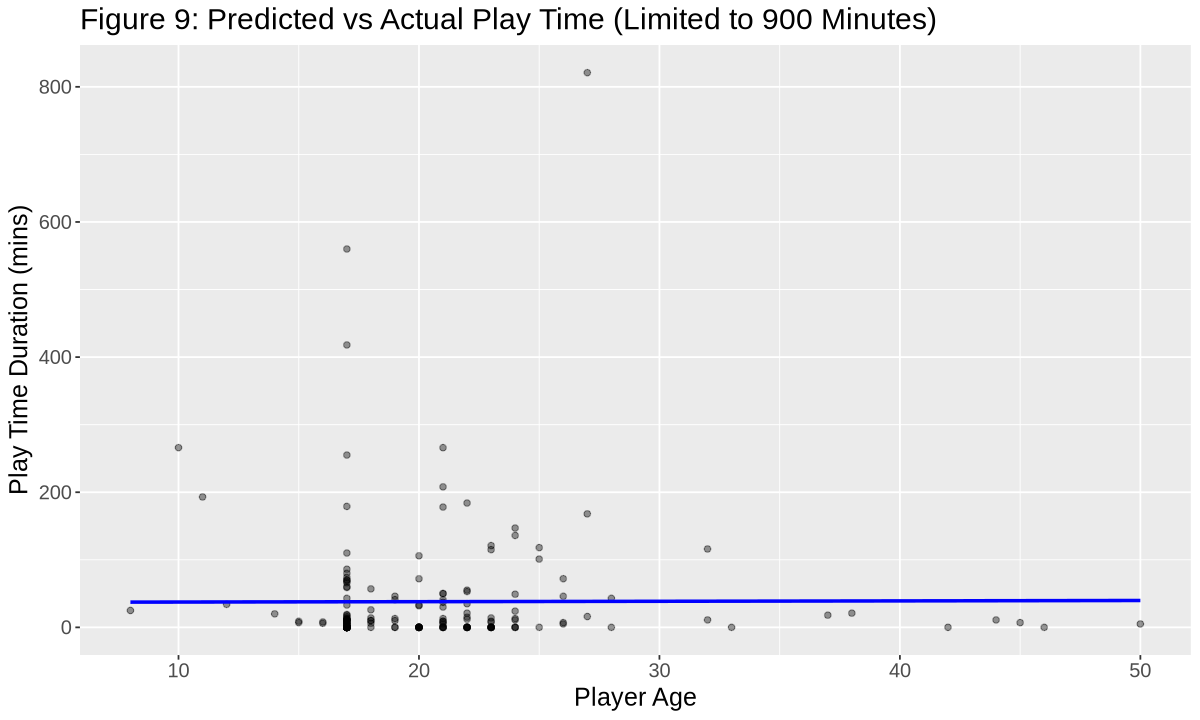

In [22]:
options(repr.plot.width = 10, repr.plot.height = 6) 

age_prediction_grid <- tibble(
    age = c(
        combined_data |> select(age) |> min(),
        combined_data |> select(age) |> max()
    )
)

data_preds <- lm_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

lm_plot_final <- ggplot(combined_data, aes(x = age, y = total_duration_min)) +
  geom_point(alpha = 0.4) +
  geom_line(data = data_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Play Time Duration (mins)") +
  ggtitle("Figure 9: Predicted vs Actual Play Time (Limited to 900 Minutes)")+
  theme(text = element_text(size = 15))

lm_plot_final

Because we used linear regression, we can quantify the relationship with a mathematical equation explaining that the predictor affects the predictions. The coefficients of the line can be found with the `extract_fit_parsnip()` function.

#### Table 5. Relationship Coefficients

In [23]:
coeffs <- lm_fit |>
             extract_fit_parsnip() |>
             tidy()
coeffs 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),36.86973745,28.302529,1.30270117,0.1949111
age,0.05762485,1.320108,0.04365161,0.9652471


Extracting the coefficients from the model, we can find that the equation of the regression line is:

#### $Play Time = 0.0576(Player Age) + 36.8697$

The equation shows that the model predicts that playtime starts at 36.9 minutes for age 0 and that with every increasing age, the play time of the player increases by 0.0576 minutes. 

# Discussion

In this project, we aimed to predict player playtime based on age using a linear regression model. Although the model provided some insights, it was ultimately limited by the insufficient amount of data. With an RMSE of 79.05, the prediction error was relatively substantial, which highlights the model’s difficulty in accurately estimating the playtime of players. A prediction error of 79 minutes means that, on average, the model’s predicted playtime deviated by over an hour from the actual value, which significantly impacts the reliability of the predictions. This high error suggests that additional data or more complex modeling techniques may be necessary to improve the accuracy and robustness of future predictions.

This result aligns with our expectations, as the dataset contained only 188 observations after wrangling, which limited the model's capacity to generalize effectively. The small sample size reduced the model’s ability to capture broader patterns in the data, highlighting the need for a larger and more diverse dataset to improve predictive performance and enhance the model's accuracy. Furthermore, with only 188 observations, the model fails to capture variability of the relationships between age and playtime. Having a larger dataset would provide our model with more training data to detect meaningful patterns and relationships, thus generating a more accurate and reliable model.

Despite its shortcomings, our analysis did reveal certain trends. Younger players tended to log more playtime, which suggests that Minecraft would benefit from targeting this demographic in its marketing strategies. For the purposes of the project, it is suggested to market and engage a younger demographic, under 25 years old as they are the players that are identified to contribute the most time to PlaiCraft. This is expected because most players are university students who were asked to participate in the study, specifically students enrolled in data science courses. Therefore, a majority of players would be between the asge of 17-25. Some students may have asked others to play in the server for them which gives more variation in the ages of players or there may be older university students participating in the study. 

Additionally, our findings from this project point to several potential questions for further investigation. One area of interest would be examining how player engagement evolves over time, which could give us insights into player retention patterns. As well, we’d be interested in exploring how potential game updates or events could affect player behavior. 

Ultimately, while the linear model had certain limitations and did not necessarily perform as well as hoped, it still provided valuable insights that can help guide potential future research. 
